# Условный автоэнкодер

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchsummary import summary
import torch.nn.functional as F

import torch.optim as optim

## Dataset

In [ ]:
# определяем трансформацию
transform = transforms.Compose([
    transforms.ToTensor(),  # преобразует картинку в тензор PyTorch типа float с значениями в диапазоне от 0 до 1.
    transforms.Resize((64, 64)), # изменяет размер картинок до 64x64 пикселей.
])

# Загрузка датасета с примененными преобразованиями.
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

состав датасета: This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

10 лейблов от 0 до 9


In [ ]:
'''1. DataLoader берет train_dataset и разбивает его на "пакеты" (batches) заданного размера.
   2. При каждой итерации обучения модели DataLoader предоставляет новый пакет данных.
   3. shuffle=True <--- пакеты данных на каждой итерации
   '''
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# До улучшений

## Model

слой-условие - на вход и энкодеру, и декодеру будем передавать дополнительно еще и лейбл.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=64, condition_dim=10): # condition_dim=10,  т.к. 10 классов в FashionMNIST
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1), # padding=1 <-- добавляем по 1 пикселю по краям матрицы; stride=2 - шаг для ядра свертки
            nn.LeakyReLU(), # 32*32   и 32 канала
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(), # 16*16 и 64 канала
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(), # 8*8 и 128 каналов
            nn.Flatten(), # выпрямляем в вектор
            nn.Linear(in_features=128*8*8, out_features=dim_code)
        ) # на выходе только вектор длины 64

        self.decode_input = nn.Linear(in_features=dim_code+condition_dim, out_features=128*8*8) # на вход еще метка класса, закодированная one-hot кодированием

        # обратные операции
        self.decoder = nn.Sequential(
            # на вход (batch_size, 128, 8, 8)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(), # (batch_size, 64, 16, 16)
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(), # (batch_size, 32, 32, 32)
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # (batch_size, 1, 64, 64)
        )

    def decode(self, x):
        to_decoder = self.decode_input(x) # подаем вектор длины 128*8*8
        to_decoder = to_decoder.view(-1, 128, 8, 8) # в тензор с размерностями 128, 8, 8
        reconstruction = self.decoder(to_decoder) # применяем декодер
        return reconstruction

    def forward(self, x, condition):
        # кодирование
        latent_code = self.encoder(x)
        condition_code = F.one_hot(condition, num_classes=10).float() # производим one-hot кодирование
        combined = torch.cat([latent_code, condition_code], dim=1) # конкатенация тензоров по оси 1
        # декодирование
        reconstruction = self.decode(combined)

        return reconstruction

## Training

In [ ]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []
    model.to(device) # где будут расчеты

    # для каждой эпохи обучения
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = []
        tqdm_iterator = tqdm(dataloader) # чтобы видеть progress bar

        # для каждого батча
        for images, labels in tqdm_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            reconstructed = model(images, labels)  # подгрузка в модель батча картинок с метками
            loss = criterion(reconstructed, images) # вычисляем значение loss-функции на батче
            loss.backward() # обратное распространение ошибки
            optimizer.step() # Обновляем параметры модели, используя вычисленные градиенты

            train_epoch_loss.append(loss.item())
            tqdm_iterator.set_description(f"Epoch: {epoch+1}, Loss: {loss:.5f}")

        train_loss.append(np.mean(train_epoch_loss))

    return train_loss # значение loss-функции

In [ ]:
criterion = nn.MSELoss()
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = train_autoencoder(
    model=autoencoder,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

Epoch: 15, Loss: 0.00259: 100%|██████████| 7500/7500 [01:10<00:00, 106.14it/s]


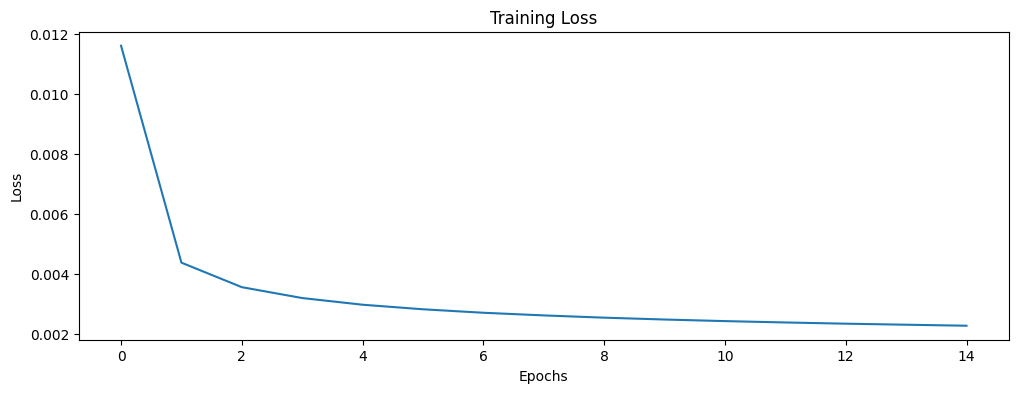

In [ ]:
# визуализация
plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## Test

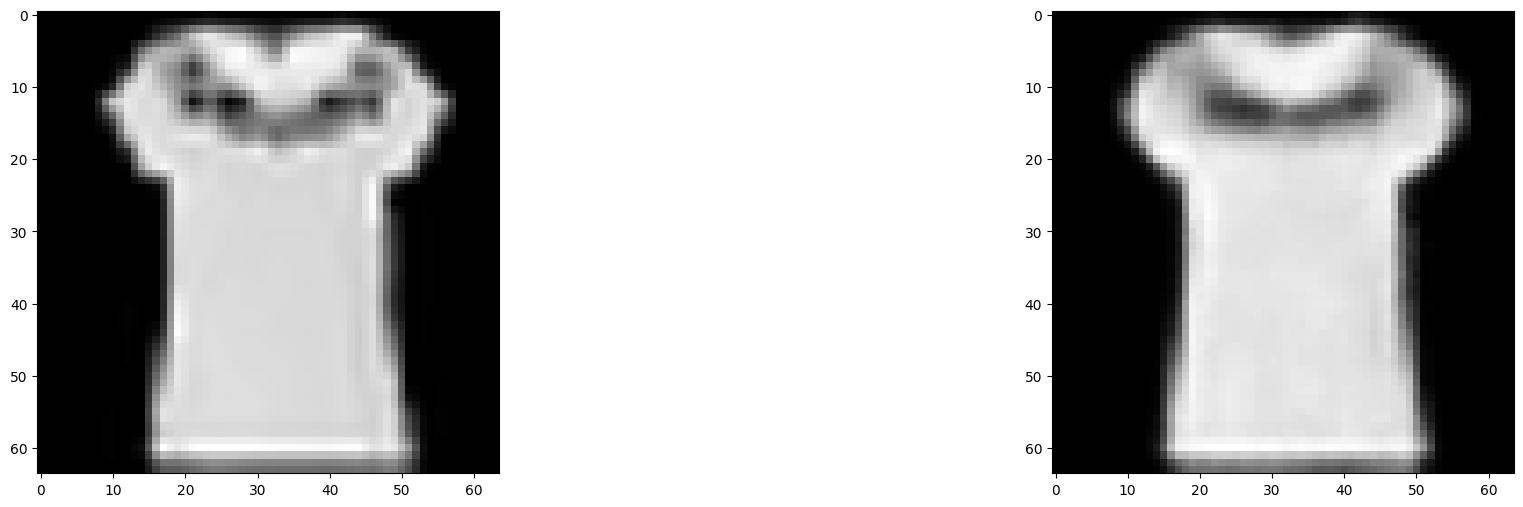

In [ ]:
with torch.no_grad(): # просто делаем предсказание, надо отключить градиенты
    batch, labels = next(iter(dataloader))
    batch, labels = batch.to(device), labels.to(device)
    pred = autoencoder(batch, labels)
    reconstructed_img, original_img = pred[0], batch[0]
    im, gt = reconstructed_img[0].squeeze(), original_img.squeeze()

    fig = plt.figure(figsize=(24, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(gt.cpu(), cmap='gray')
    ax2.imshow(im.cpu(), cmap='gray')
    plt.show()


# Улучшение

\+ BatchNorm2d и Dropout

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=64, condition_dim=10):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=128*8*8, out_features=dim_code)
        )

        self.decode_input = nn.Linear(in_features=dim_code+condition_dim, out_features=128*8*8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def decode(self, x):
        to_decoder = self.decode_input(x) # подаем вектор длины 128*8*8
        to_decoder = to_decoder.view(-1, 128, 8, 8) # в тензор с размерностями 128, 8, 8
        reconstruction = self.decoder(to_decoder) # применяем декодер
        return reconstruction

    def forward(self, x, condition):
        # кодирование
        latent_code = self.encoder(x)
        condition_code = F.one_hot(condition, num_classes=10).float() # производим one-hot кодирование
        combined = torch.cat([latent_code, condition_code], dim=1) # конкатенация тензоров по оси 1
        # декодирование
        reconstruction = self.decode(combined)

        return reconstruction

In [ ]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []
    model.to(device) # где будут расчеты

    # для каждой эпохи обучения
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = []
        tqdm_iterator = tqdm(dataloader) # чтобы видеть progress bar

        # для каждого батча
        for images, labels in tqdm_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            reconstructed = model(images, labels)  # подгрузка в модель батча картинок с метками
            loss = criterion(reconstructed, images) # вычисляем значение loss-функции на батче
            loss.backward() # обратное распространение ошибки
            optimizer.step() # Обновляем параметры модели, используя вычисленные градиенты

            train_epoch_loss.append(loss.item())
            tqdm_iterator.set_description(f"Epoch: {epoch+1}, Loss: {loss:.5f}")

        train_loss.append(np.mean(train_epoch_loss))

    return train_loss # значение loss-функции




Epoch: 15, Loss: 0.00357: 100%|██████████| 7500/7500 [01:19<00:00, 94.72it/s] 


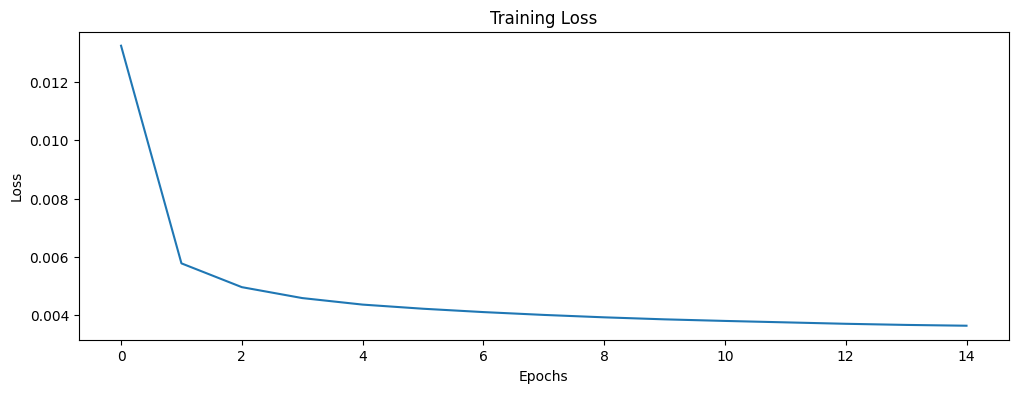

In [ ]:
criterion = nn.MSELoss()
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #фикс ошибки

loss = train_autoencoder(
    model=autoencoder,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


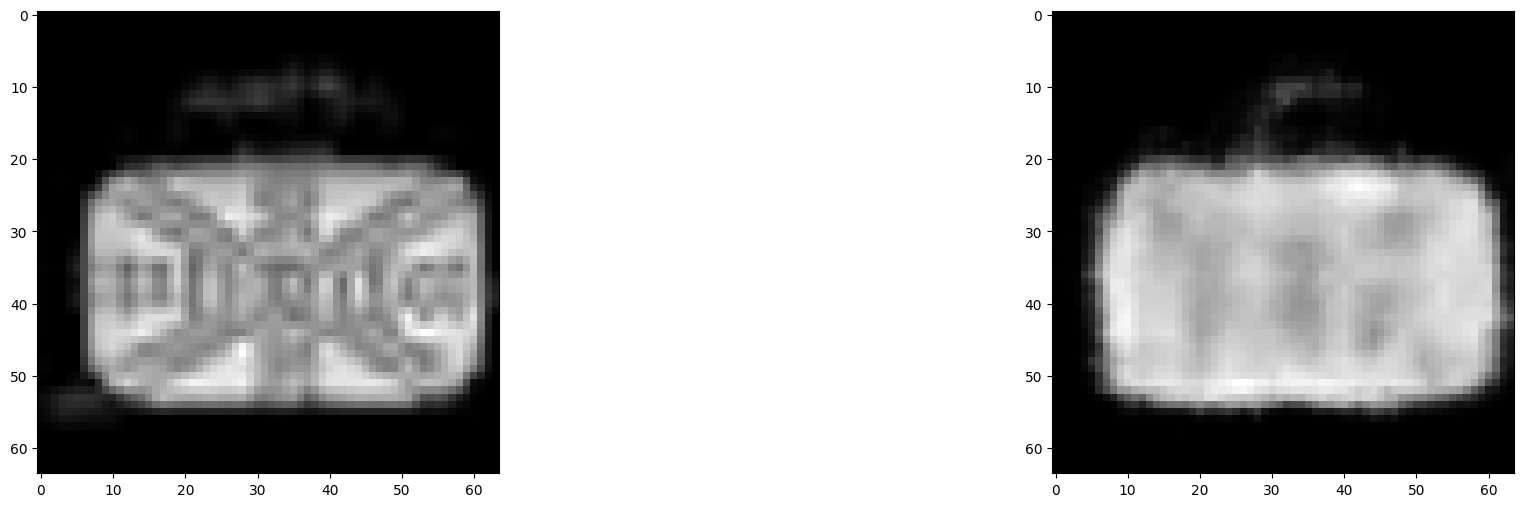

In [ ]:
with torch.no_grad(): # просто делаем предсказание, надо отключить градиенты
    batch, labels = next(iter(dataloader))
    batch, labels = batch.to(device), labels.to(device)
    pred = autoencoder(batch, labels)
    reconstructed_img, original_img = pred[0], batch[0]
    im, gt = reconstructed_img[0].squeeze(), original_img.squeeze()

    fig = plt.figure(figsize=(24, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(gt.cpu(), cmap='gray')
    ax2.imshow(im.cpu(), cmap='gray')
    plt.show()

## Комментарии:
1) Зачем добавлять условия в автоэнкодер? Как это влияет на генерацию?

При добавлении условий в автоэнкодер мы по сути управляем процессом генерации изображений. Вместо того, чтобы просто реконструировать входные данные, автоэнкодер с условиями учится генерировать данные, соответствующие заданным условиям.
Плюсы подхода:
 - Повышается качество генерируемых изображений;
 - Генерация становится более контролируемой;
 - Модель становится более гибкой и может использоваться для решения более широкого спектра задач.

 Минусы:
 - В некоторых случаях, условие может быть слишком абстрактным или неточным, что приведет к некачественной генерации.

2) Какие слои помогают восстанавливать изображение к исходному размеру в декодировщике? (*) Какие есть аналоги этого слоя? В чем их различие? Какие у каждого слоя плюсы и минусы?

а) ConvTranspose (Transposed Convolution- транспонированная свертка):
Производит обратную свертку.Этот слой примеяет обучаемые фильтры для расширения пространственных измерений входного тензора. Аналогом является Convolutional Layer (свертка обычная). Разница в том, что прямая свертка уменьшает размеры изображения с помощью скользящего фильтра, а транспонированная расширяет размеры.
 -  Плюсы: просто реализуется, может быть использован для восстановления формы/контента изображения; можно с его помощью изучать сложные паттерны при увеличении размера.
  - Минусы: Может быть более ресурсоемким, чем другие слои; если неправильно используется, то может давать артефакты.

б) Upsampling Layer (Nearest Neighbor / билинейнвя интерполяция/ бикубическая интерполяция/ Nearest-neighbor + свертка) Производит репликацию (дублирование) или интерполяции значений пикселей. Nearest Neighbor - в нем дублируются соселние пиксели, а билинейная/бикубическая интерполяция использует средневзвешенные значения для получения более гладких результатов. Аналогом является интерполяция в обработке изображений. Отличие: вместо того, чтобы изучать, как увеличить размер изображения, эти слои используют предопределенные методы (например, метод ближайшего соседа, билинейный) для увеличения размера изображения.

Преимущества:
- быстрота работы
- можно восстанавливать мелкие детали, которые теряются при сжатии

Недостатки:
- При репликации становятся заметны блочные артефакты, которые делают изображение "пиксельным", ну и также не наблюдается сглаживание.
- билинейная и бикубическая интерполяции могут привести к размытию деталей
- нет параметров для настройки

в) Unpooling Layer\
Если в качестве примера взять maxunpooling, то суть в следующем:
Слой использует объединенные карты объектов и "разворачивает" их обратно, помещая максимальные значения обратно в соответствующие им местоположения на карте объектов большего размера.
Аналог: pooling слои.

Недостатки:
- Чувствителен к выбору метода пулинга


Transposed convolution является наиболее гибким методом, способным к изучению сложных преобразований, но может содержать артефакты.
Nearest-neighbor + convolutionслой быстрее и стабильнее, но является менее гибким.
Max-unpooling эффективнее всего в сочетании с max-pooling, но не является таким универсальным, как другие методы (чаще всего имеено maxpooling/max unpooling)


3) Как можно улучшить архитектуру автоэнкодера? Какие методы помогали вам при обучении? Что повлияло на сходимость? 

Улучшение архитектуры автоэнкодера:

- Использование более глубоких сетей - более трудные зависимости может уловить
- Экспериментирование с функциями активации - может помочь
- использование регуляризаций - борьба с переобучением
- Batch Normalization - помогает избежать проблем с исчезновением / взрывом градиента и стабилизировать обучение за счет нормализации выходных данных слоев (улучшает сходимость и обеспечивает более высокую скорость обучения) (*)
- Dropout (случайным образом отключаются нейроны, помогая предотвратить переобучение) (*)
- настройка Learning Rate (Staple или ReduceLROnPlateau) и оптимизатора (Adam, RMSProp и т.д.)
- Gradient Clipping ограничение на градиенты для стабильности

